In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dfM2 = pd.read_csv('datasets/HousingPrices-Amsterdam-August-2021.csv')
dfM2.head()

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


In [3]:
dfM2.drop('Unnamed: 0', axis=1, inplace=True)
dfM2.head()

#checking null values
dfM2.isnull().sum()

Address    0
Zip        0
Price      4
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

In [4]:
dfM2.dropna(inplace=True)

In [5]:
def get_info(_column, df):
    column_obj = eval(f'df.{_column}')
    print(f'min  of {_column} = {column_obj.min()}')
    print(f'max  of {_column} = {column_obj.max()}')
    print(f'mean of {_column} = {column_obj.mean()}')
    print(f'sdv  of {_column} = {column_obj.std()}')
    
    
def print_info(df: pd.DataFrame):
    for column in df.select_dtypes(include=np.number):
        get_info(column, df)
        print()

print_info(dfM2)

min  of Price = 175000.0
max  of Price = 5950000.0
mean of Price = 622065.4195652173
sdv  of Price = 538994.1753643249

min  of Area = 21
max  of Area = 623
mean of Area = 95.60760869565217
sdv  of Area = 56.84969919845171

min  of Room = 1
max  of Room = 14
mean of Room = 3.5641304347826086
sdv  of Room = 1.5710299998547912

min  of Lon = 4.644819
max  of Lon = 5.029122
mean of Lon = 4.8886521308078175
sdv  of Lon = 0.053117891618517786

min  of Lat = 52.291519
max  of Lat = 52.423805
mean of Lat = 52.363271458425636
sdv  of Lat = 0.024054332531420985



In [6]:
import folium
from branca.colormap import linear

# Create a color palette using the viridis colormap
color_map = linear.viridis.scale(dfM2['Price'].min(), dfM2['Price'].max())

# Create a map with CartoDB tiles and attribution
m = folium.Map(
    location=[dfM2['Lat'].mean(), dfM2['Lon'].mean()],
    tiles="CartoDB positron",
    attr="© <a href='https://carto.com/attributions'>CartoDB</a> contributors"
)

# Add circles to the map with smaller radius
for index, row in dfM2.iterrows():
    folium.Circle(
        location=[row['Lat'], row['Lon']],
        radius=50,  # Adjust the radius as needed
        color=color_map(row['Price']),
        fill=False,
        popup=row['Address']
    ).add_to(m)

# Add a color legend
color_map.add_to(m)

# Show the map
m


<Axes: >

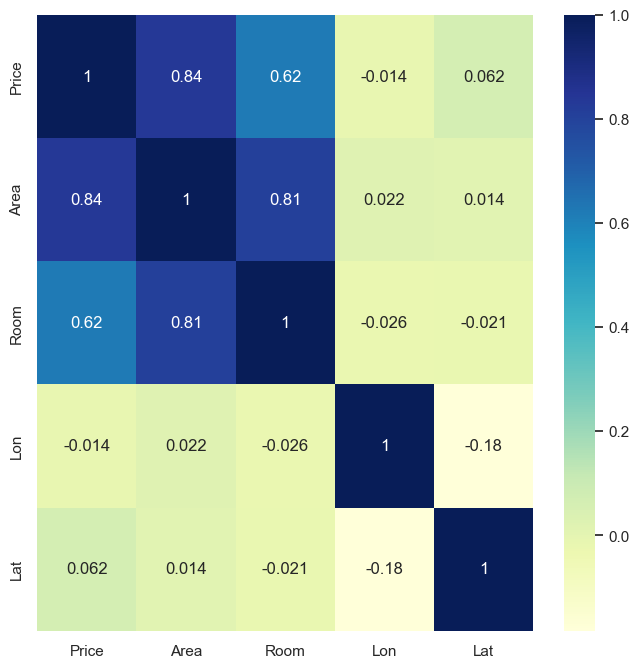

In [7]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(dfM2.corr(numeric_only=True), cmap='YlGnBu', annot=True)

In [8]:
def correlation_trashold(df):
    correlation_df = df.corr(numeric_only=True)
    threshold = 0.3
    filtered = np.abs(correlation_df['Price']) > threshold
    wanted_features = correlation_df.columns[filtered].tolist()
    return wanted_features

wanted_features = correlation_trashold(dfM2)
wanted_features

['Price', 'Area', 'Room']

In [9]:
dfM2 = dfM2.loc[:, wanted_features]
dfM2.head()

,Price,Area,Room
0,685000.0,64,3
1,475000.0,60,3
2,850000.0,109,4
3,580000.0,128,6
4,720000.0,138,5


outliers and normalization the data

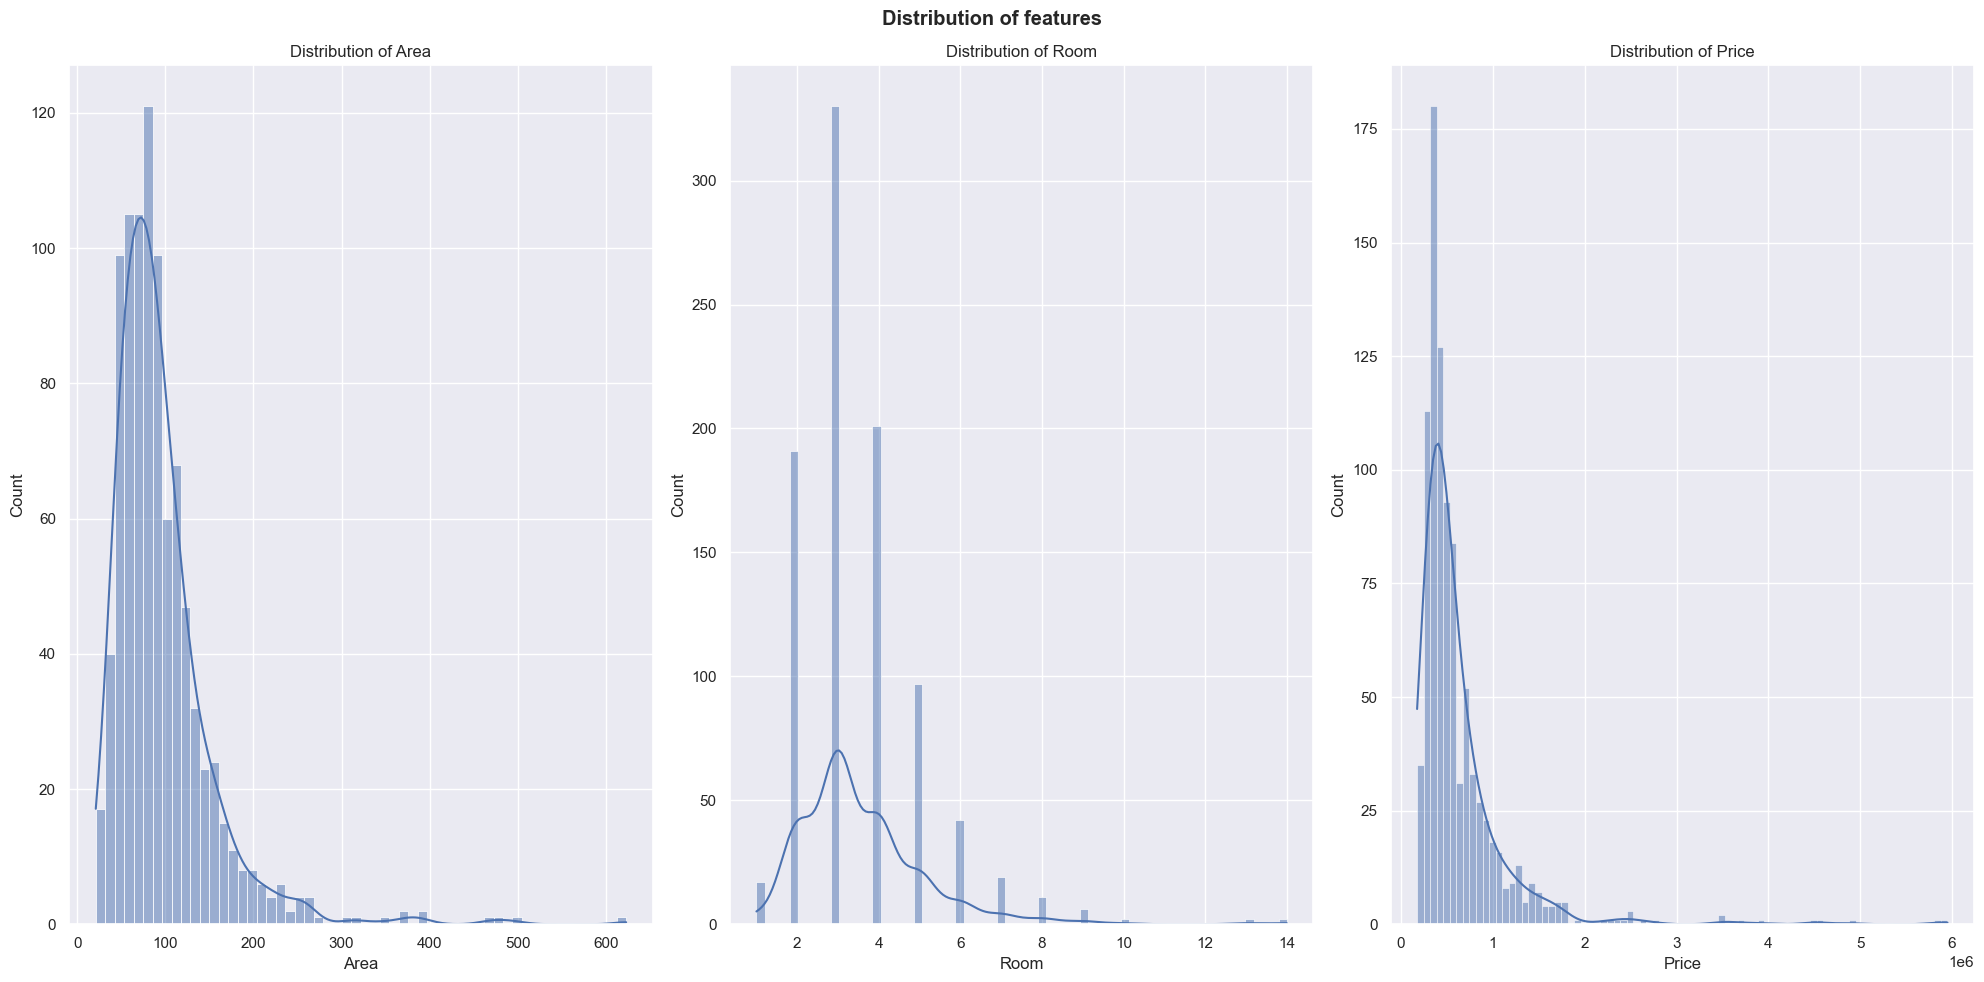

In [10]:
# Check distribution of Area, Room, and Price
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

sns.histplot(dfM2['Area'], ax=ax1, kde=True)  # You can set kde=True to include the KDE plot
ax1.set_title('Distribution of Area')

sns.histplot(dfM2['Room'], ax=ax2, kde=True)
ax2.set_title('Distribution of Room')

sns.histplot(dfM2['Price'], ax=ax3, kde=True)
ax3.set_title('Distribution of Price')

plt.suptitle('Distribution of features', fontweight='bold')
plt.tight_layout()
plt.show()

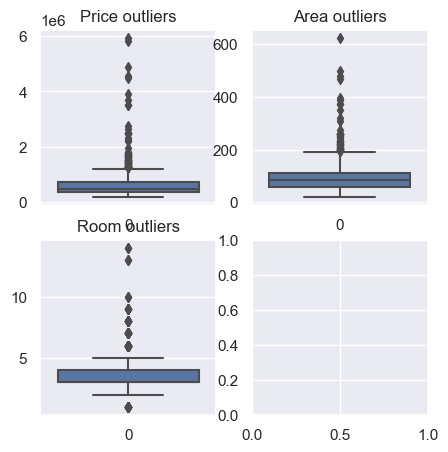

In [11]:
# Check outlier of Area, Room and Price
def outlier(df):
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    axes = axs.ravel()
    for variable, ax in zip(df._get_numeric_data().columns, axes.flatten()):
        sns.boxplot(df[variable], ax=ax)
        ax.set_title(f'{variable} outliers')
        
outlier(dfM2)

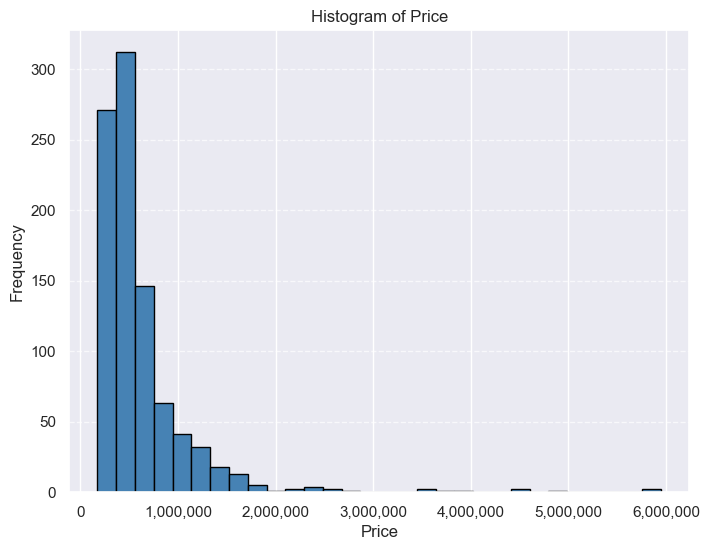

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(dfM2['Price'], bins=30, color='steelblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.minorticks_on()
plt.show()

<Axes: xlabel='Room'>

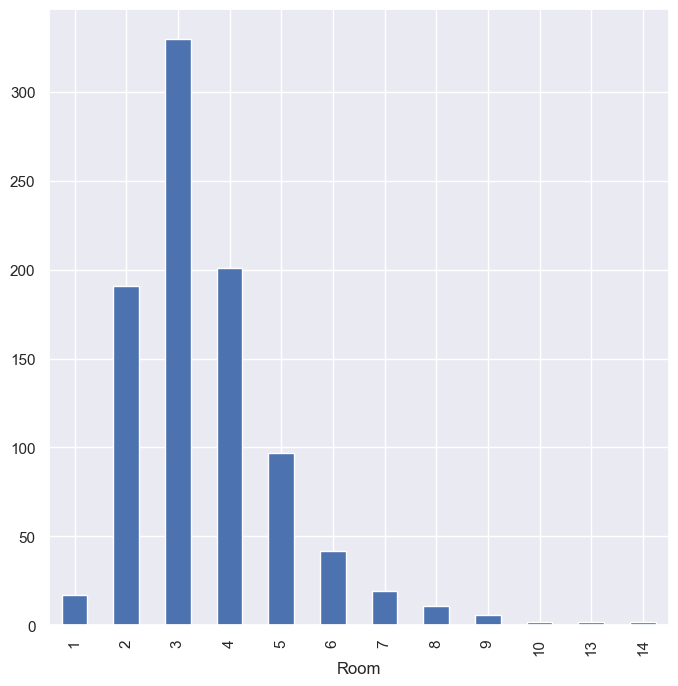

In [13]:
# visualize the distribution how many houses have how many rooms 
houses_rooms = dfM2.groupby('Room').size()
houses_rooms.plot.bar()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Split the data for test and train sets
def split_test_train_set(data):
    x, y = data.drop('Price', axis=1), data['Price']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
    return x_train, x_test, y_train, y_test

# Linear Regression Model


In [15]:
x_train, x_test, y_train, y_test = split_test_train_set(dfM2)

reg = LinearRegression()

# Train the model
reg.fit(x_train, y_train)

LinearRegression()

In [16]:
reg.score(x_test, y_test)

0.6330242047201158

# Classification

In [17]:
from sklearn.preprocessing import PowerTransformer

def power_transformer(df):
    # Exclude the 'room' column from the transformation
    columns_to_transform = [col for col in df.columns if col != 'Room']
   
    pt = PowerTransformer(method='box-cox')
    transformed_data = pt.fit_transform(df[columns_to_transform] + 0.000001)
    transformed_df = pd.DataFrame(transformed_data, columns=columns_to_transform, index=df.index)
    result_df = pd.concat([transformed_df, df['Room']], axis=1)
    return result_df

# Apply the power_transformer function
power_transformer_df = pd.DataFrame(power_transformer(dfM2), columns=dfM2.columns)



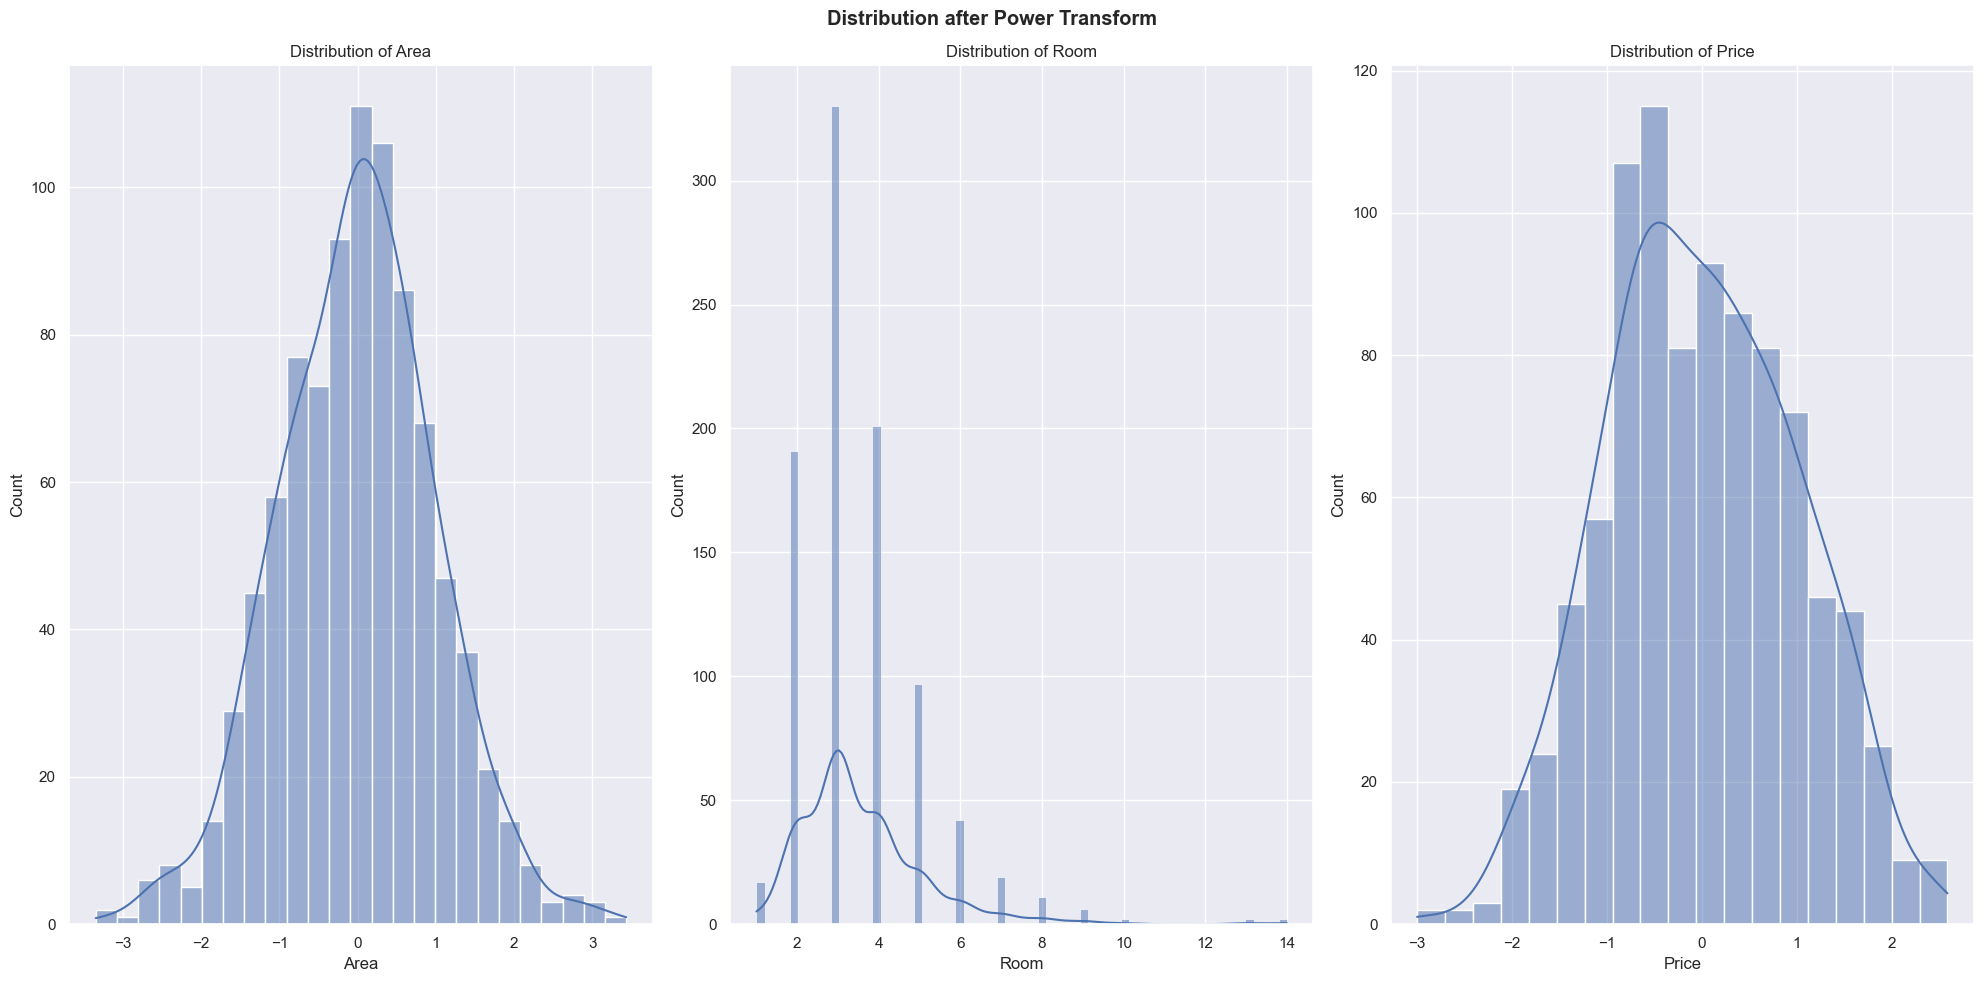

In [18]:
# Check distribution of Area, Room, and Price
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

sns.histplot(power_transformer_df['Area'], ax=ax1, kde=True)  # You can set kde=True to include the KDE plot
ax1.set_title('Distribution of Area')

sns.histplot(power_transformer_df['Room'], ax=ax2, kde=True)
ax2.set_title('Distribution of Room')

sns.histplot(power_transformer_df['Price'], ax=ax3, kde=True)
ax3.set_title('Distribution of Price')

plt.suptitle('Distribution after Power Transform', fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
# Define the bin width (500,000 in this case)
bin_width = 500000

# Calculate the number of bins needed
num_bins = int((dfM2['Price'].max() - dfM2['Price'].min()) / bin_width)

# Create the bin edges
bin_edges = [dfM2['Price'].min() + i * bin_width for i in range(num_bins + 1)]

# Create labels for the bins (one fewer than the number of bin edges)
bin_labels = [f'{int(i)}-{int(i+bin_width-1)}' for i in bin_edges[:-1]]

# Add a category for 'Outlier' to the labels
bin_labels.append('Outlier')

# Use pd.cut to assign each value to a bin and categorize outliers
dfM2['Price'] = pd.cut(dfM2['Price'], bins=bin_edges + [dfM2['Price'].max() + 1], labels=bin_labels, include_lowest=True, right=False, duplicates='raise')

# Check for null values
dfM2.isnull().sum()


Price    0
Area     0
Room     0
dtype: int64

In [20]:
dfM2['Area'] = pd.qcut(dfM2['Area'], q=10, labels=False, duplicates='drop')


In [21]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dfM2.isnull().sum()

Price    0
Area     0
Room     0
dtype: int64

In [22]:
x_train, x_test, y_train, y_test = split_test_train_set(dfM2)

In [23]:
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [24]:
clf.score(x_test, y_test)

0.7989130434782609

In [25]:
from sklearn.neighbors import KNeighborsClassifier 

In [26]:
x_train, x_test, y_train, y_test = split_test_train_set(dfM2)
k = 10  
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.7608695652173914